# Modelisation of credit data

In [3]:
import pandas as pd
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
import xgboost as xgb
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 150)

In [4]:
## Load data
data = pd.read_csv("Data/cleaned/data_train.csv")
data.drop(columns=["SK_ID_CURR"], inplace=True)
data

,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MAX_MAX,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Interbank credit_MEAN,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,INSTAL_COUNT,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_SK_DPD_MIN,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,TARGET
0,1,0,202500.0,406597.5,0.018801,-9461,-637.0,-3648.0,-2120,2,10,0,0,0,0,0.262949,0.139376,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1437.0,-103.0,0.0,31988.565,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.406960,0.255682,0.000000,0.0,0.175426,0.161932,9251.775,9251.775,9.0,9.0,-606.0,-606.0,24.000000,-1.0,-10.000000,19.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,19.0,-1.0,-1.0,869873.535,1354829.265,1350000.0,1350000.0,1125000.0,112500.0,1529847.0,720177.435,2060030.16,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1
1,0,0,270000.0,1293502.5,0.003541,-16765,-1188.0,-1186.0,-291,1,11,0,0,0,0,0.622246,0.896010,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,

In [5]:
# Creation of trainning and test dataset
X_train, X_test, y_train, y_test = train_test_split(
    data[data.columns[data.columns != 'TARGET']],
    data["TARGET"],
    test_size=0.3,
    random_state=3,
    stratify=data["TARGET"],
)

In [6]:
X_train

,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MAX_MAX,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Interbank credit_MEAN,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,INSTAL_COUNT,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_SK_DPD_MIN,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX
293239,1,0,292500.0,760225.5,0.046220,-11577,-1384.0,-3901.0,-3287,1,12,0,0,0,0,0.759447,0.672243,-1639.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-2118.0,-1480.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,1.000000,0.833333,0.240741,0.4,1.000000,1.000000,2250.000,52156.665,11.0,21.0,-2888.0,-109.0,11.428571,-2.0,-42.594595,74.0,0.0,0.932432,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,88.0,-12.0,-2.0,0.000,146804.850,45000.0,247500.0,0.0,0.0,0.0,1935.000,148763.70,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178837,1,0,135000.0,360000.0,0.025164,-8416,-1717.0,-7716.0,-1081,2,14,0,0,0,0,0.547058,0.626304,-925.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.

In [7]:
# Ratio Target = 0 / Target = 1 in train dataset
print(
    "There is",
    (y_train.value_counts()[1] / len(X_train)) * 100,
    "% of clients that did not paid their loan in the trainning set",
)

There is 8.072788426695904 % of clients that did not paid their loan in the trainning set


In [8]:
# Ratio Target = 0 / Target = 1 in test dataset
print(
    "There is",
    (y_test.value_counts()[1] / len(X_test)) * 100,
    "% of clients that did not paid their loan in the trainning set",
)

There is 8.073450185901814 % of clients that did not paid their loan in the trainning set


In [9]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Sets the current active experiment
# returns the Experiment metadata
imbalance_experiment = mlflow.set_experiment("imbalance")

## Correcting the imbalanced data
    In a first time, I am going to look at the best of dealing with the fact that our data contain mainly information about client which did reimburse loans. I am going to a Logistic regression in order to identify what between overfitting, underfitting or class weight brings the best results.

    Moreover, our goal is to avoid 
    (TP + TN) / (TP + TN + 10 x FN + FP)

    Ce score varie entre 0 et 1, où 1 représente le meilleur score possible. Il pondère les faux négatifs 10 fois plus que les faux positifs et inclut les vrais positifs et vrais négatifs pour une évaluation plus complète.

### Reference

In [11]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "LR_imbalanced_scaled_data"
# Define an artifact path that the model will be saved to.
artifact_path = "lr_imbalanced_scaled"

pipeline = Pipeline([("scaler", RobustScaler()), ("model", LogisticRegression())])

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)

    # Faire des prédictions
    predictions = pipeline.predict(X_test)

    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
        "AUC": roc_auc_score(y_test, predictions),
        "F1_score": f1_score(y_test, predictions),
        "Precission": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "True_negative": confusion_mat[0][0],
        "False_negative": confusion_mat[1][0],
        "True_positive": confusion_mat[1][1],
        "False_positive": confusion_mat[0][1],
        "Score": (confusion_mat[1][1] * 0.2 + confusion_mat[0][0] * 0.8)
        / (
            confusion_mat[1][1] * 0.2
            + confusion_mat[0][0] * 0.8
            + 10 * confusion_mat[1][0] * 0.8
            + confusion_mat[0][1] * 0.2
        ),
    }

    mlflow.log_params(
        {
            "lenght_0": sum(y_train == 0),
            "lenght_1": sum(y_train == 1),
            "Sampling": "None",
        }
    )
    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)


🏃 View run LR_imbalanced_scaled_data at: http://127.0.0.1:8080/#/experiments/576506674894813173/runs/1e2abdb88b5f427f921a4ab0000c22c8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/576506674894813173


### Weighted classes
    Logistic regression with weighted classes option

In [13]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "LR_imbalanced_scaled_data_weighted"
# Define an artifact path that the model will be saved to.
artifact_path = "lr_weight"

pipeline = Pipeline([("scaler", RobustScaler()), ("model", LogisticRegression(class_weight="balanced"))])

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)

    # Faire des prédictions
    predictions = pipeline.predict(X_test)

    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
    "AUC": roc_auc_score(y_test, predictions),
    "F1_score": f1_score(y_test, predictions),
    "Precission": precision_score(y_test, predictions),
    "Recall": recall_score(y_test, predictions),
    "True_negative": confusion_mat[0][0],
    "False_negative": confusion_mat[1][0],
    "True_positive": confusion_mat[1][1],
    "False_positive": confusion_mat[0][1],
    "Score":  (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
     }

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)
    
    mlflow.log_params(
        {
            "lenght_0": sum(y_train == 0),
            "lenght_1": sum(y_train == 1),
            "Sampling": "Weight classes",
        }
    )


🏃 View run LR_imbalanced_scaled_data_weighted at: http://127.0.0.1:8080/#/experiments/576506674894813173/runs/df567ae518094c319888e292abc770ff
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/576506674894813173


### Oversampling
    Oversampling using SMOTE algorithm.

In [15]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "LR_smote_data"
# Define an artifact path that the model will be saved to.
artifact_path = "lr_SMOTE"

pipeline = ImbPipeline([("Oversampling", SMOTE(random_state=3)), ("scaler", RobustScaler()), ("model", LogisticRegression())])

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)
    # Récupérer X_resampled et y_resampled après SMOTE
    X_train_resample, y_train_resample = pipeline.named_steps['Oversampling'].fit_resample(X_train, y_train)

    # Faire des prédictions
    predictions = pipeline.predict(X_test)
    
    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
    "AUC": roc_auc_score(y_test, predictions),
    "F1_score": f1_score(y_test, predictions),
    "Precission": precision_score(y_test, predictions),
    "Recall": recall_score(y_test, predictions),
    "True_negative": confusion_mat[0][0],
    "False_negative": confusion_mat[1][0],
    "True_positive": confusion_mat[1][1],
    "False_positive": confusion_mat[0][1],
    "Score":  (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
     }
    
    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)
    
    # Log the parameters used for the model fit
    mlflow.log_params(
        {
            "lenght_0": sum(y_train_resample == 0),
            "lenght_1": sum(y_train_resample == 1),
            "Sampling": "SMOTE",
        }
    )


🏃 View run LR_smote_data at: http://127.0.0.1:8080/#/experiments/576506674894813173/runs/a8af5b13798e4ee8888207c61c577f76
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/576506674894813173


### NearMiss Undersampling
Undersampling using NearMiss Algorithm.

In [17]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "LR_nearmiss_data"
# Define an artifact path that the model will be saved to.
artifact_path = "lr_nearmiss"

pipeline = ImbPipeline([("Undersampling", NearMiss()), ("scaler", RobustScaler()), ("model", LogisticRegression())])

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)
    # Récupérer X_resampled et y_resampled après SMOTE
    X_train_resample, y_train_resample = pipeline.named_steps['Undersampling'].fit_resample(X_train, y_train)

    # Faire des prédictions
    predictions = pipeline.predict(X_test)
    
    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
    "AUC": roc_auc_score(y_test, predictions),
    "F1_score": f1_score(y_test, predictions),
    "Precission": precision_score(y_test, predictions),
    "Recall": recall_score(y_test, predictions),
    "True_negative": confusion_mat[0][0],
    "False_negative": confusion_mat[1][0],
    "True_positive": confusion_mat[1][1],
    "False_positive": confusion_mat[0][1],
    "Score":  (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
     }
    
    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)
    
    # Log the parameters used for the model fit
    mlflow.log_params(
        {
            "lenght_0": sum(y_train_resample == 0),
            "lenght_1": sum(y_train_resample == 1),
            "Sampling": "Near Miss",
        }
    )


🏃 View run LR_nearmiss_data at: http://127.0.0.1:8080/#/experiments/576506674894813173/runs/5b18363df30f45639154d7690d26d5c6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/576506674894813173


### Edited Nearest Neigbours Undersampling
    Undersampling with EditedNearestNeigbours Algorithm.

In [19]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "LR_EditedNearestNeighbours_data"
# Define an artifact path that the model will be saved to.
artifact_path = "lr_ENN"

pipeline = ImbPipeline([("ENN", EditedNearestNeighbours()), ("scaler", RobustScaler()), ("model", LogisticRegression())])

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)
    # Récupérer X_resampled et y_resampled après SMOTE
    X_train_resample, y_train_resample = pipeline.named_steps['ENN'].fit_resample(X_train, y_train)

    # Faire des prédictions
    predictions = pipeline.predict(X_test)
    
    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
    "AUC": roc_auc_score(y_test, predictions),
    "F1_score": f1_score(y_test, predictions),
    "Precission": precision_score(y_test, predictions),
    "Recall": recall_score(y_test, predictions),
    "True_negative": confusion_mat[0][0],
    "False_negative": confusion_mat[1][0],
    "True_positive": confusion_mat[1][1],
    "False_positive": confusion_mat[0][1],
    "Score":  (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
     }
    
    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)
    
    # Log the parameters used for the model fit
    mlflow.log_params(
        {
            "lenght_0": sum(y_train_resample == 0),
            "lenght_1": sum(y_train_resample == 1),
            "Sampling": "ENN",
        }
    )


🏃 View run LR_EditedNearestNeighbours_data at: http://127.0.0.1:8080/#/experiments/576506674894813173/runs/d8a42dfde2c44d3e8ae91da845bffb1f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/576506674894813173


### Combination of Over and Undersampling

In [21]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "LR_SMOTE_Under"
# Define an artifact path that the model will be saved to.
artifact_path = "lr_SMOTE_Under"

over, under = 0.1, 0.75

pipeline = ImbPipeline([("Oversampling", SMOTE(sampling_strategy=over)), ("Undersampling", RandomUnderSampler(sampling_strategy=under)), 
                        ("scaler", RobustScaler()), ("model", LogisticRegression())])

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)
    # Récupérer X_resampled et y_resampled après SMOTE
    X_train_resample, y_train_resample = pipeline.named_steps['Undersampling'].fit_resample(X_train, y_train)

    # Faire des prédictions
    predictions = pipeline.predict(X_test)
    
    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
    "AUC": roc_auc_score(y_test, predictions),
    "F1_score": f1_score(y_test, predictions),
    "Precission": precision_score(y_test, predictions),
    "Recall": recall_score(y_test, predictions),
    "True_negative": confusion_mat[0][0],
    "False_negative": confusion_mat[1][0],
    "True_positive": confusion_mat[1][1],
    "False_positive": confusion_mat[0][1],
    "Score":  (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
     }
    
    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)
    
    # Log the parameters used for the model fit
    mlflow.log_params(
        {
            "lenght_0": sum(y_train_resample == 0),
            "lenght_1": sum(y_train_resample == 1),
            "Sampling": "SMOTE + Under",
        }
    )


🏃 View run LR_SMOTE_Under at: http://127.0.0.1:8080/#/experiments/576506674894813173/runs/779882636d304275b4f5e7239c845ccb
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/576506674894813173


## Feature selection
    Based on the previous results, the best way to deal with our imbalance dataset is to use weighted classes option. 
    I am now looking at the feature importance in this model in order to remove useless feature for the future modelling. 
### Permutation importance

In [23]:
# Permutation Importance
pipeline = Pipeline([("scaler", RobustScaler()), ("model", LogisticRegression(class_weight="balanced"))])

# Entraîner le pipeline
pipeline.fit(X_train, y_train)

model = pipeline.named_steps['model']

# Extraire les données prétraitées (transformées par le pipeline, sauf le modèle final)
X_test_transformed = pipeline.named_steps['scaler'].transform(X_test)

perm_importance = permutation_importance(
    model, X_test_transformed, y_test, n_repeats=50, random_state=3, n_jobs=-1
)
perm_importance_df = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance Mean": perm_importance.importances_mean,
        "Importance Std": perm_importance.importances_std,
    }
)
print("\nPermutation Importance:")
print(perm_importance_df.sort_values(by="Importance Mean", ascending=False))


Permutation Importance:
                              Feature  Importance Mean  Importance Std
22          AMT_REQ_CREDIT_BUREAU_QRT         0.052666        0.000702
38       BURO_CREDIT_DAY_OVERDUE_MEAN         0.052081        0.000750
21          AMT_REQ_CREDIT_BUREAU_MON         0.022590        0.000446
23         AMT_REQ_CREDIT_BUREAU_YEAR         0.008114        0.000226
19          AMT_REQ_CREDIT_BUREAU_DAY         0.006411        0.000195
..                                ...              ...             ...
87              CC_MONTHS_BALANCE_MIN        -0.029004        0.000667
97    CC_AMT_DRAWINGS_POS_CURRENT_MAX        -0.036159        0.000836
96    CC_AMT_DRAWINGS_POS_CURRENT_MIN        -0.036172        0.000847
94  CC_AMT_DRAWINGS_OTHER_CURRENT_MIN        -0.042824        0.000644
95  CC_AMT_DRAWINGS_OTHER_CURRENT_MAX        -0.042968        0.000648

[108 rows x 3 columns]


In [24]:
# List of features with no effect on the model
useless_features = perm_importance_df.loc[
    perm_importance_df["Importance Mean"] <= 0.0, "Feature"
].to_list()
len(useless_features)

71

### Data processing

In [26]:
X_train.drop(columns=useless_features, inplace=True)
X_test.drop(columns=useless_features, inplace=True)

In [27]:
X_train.to_csv("Data/cleaned/X_train.csv", index=False)
y_train.to_csv("Data/cleaned/y_train.csv", index=False)
X_test.to_csv("Data/cleaned/X_test.csv", index=False)
y_test.to_csv("Data/cleaned/y_test.csv", index=False)

## Model selection


In [130]:
X_train = pd.read_csv("Data/cleaned/X_train.csv")
y_train = pd.read_csv("Data/cleaned/y_train.csv")
y_train = y_train.values
X_test = pd.read_csv("Data/cleaned/X_test.csv")
y_test = pd.read_csv("Data/cleaned/y_test.csv")
y_test = y_test.values

In [131]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Sets the current active experiment to the "Apple_Models" experiment and
# returns the Experiment metadata
imbalance_experiment = mlflow.set_experiment("Best_model_selection")

In [132]:
# Fonction for trainning models
def test_model(X, y, X_test, y_test, model, params, name):
    """
    Here is a fonction for trainning a model in a pipeline for data X and y.
    """
    # X : X_train dataset
    # y: y_train
    # X_test, y_test: X_test, y_test
    # model: model to test
    # params: params for gridsearchcv Warning: add "model__" in order to pass the params to the model
    # name: name use for saving the run in mlflow

    # Define a run name for this iteration of training.
    # If this is not set, a unique name will be auto-generated for your run.
    run_name = name
    # Define an artifact path that the model will be saved to.
    artifact_path = name

    pipeline = Pipeline([('scaler', RobustScaler()), ('model', model)])

    # Définir la fonction Score
    def score(predict, actual):
        confusion_mat = confusion_matrix(predict, actual)
        score_metier= (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92) / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        )
        return score_metier

    # Créer un scoreur à partir de la fonction score
    score_metier = make_scorer(score, greater_is_better=True)

    with mlflow.start_run(run_name=run_name) as run:
        # Entraîner le pipeline
        grid_search = GridSearchCV(
        pipeline,
        param_grid=params,
        cv=5,
        scoring=score_metier,
        refit=True,
        n_jobs=-1,
        verbose=1,
        )

        # Fit the model
        grid_search.fit(X, y)

        # Best model
        best_model = grid_search.best_estimator_

        # Log the parameters used for the model fit
        mlflow.log_params(grid_search.best_params_)

        # Predciction
        predictions = best_model.predict(X_test)

        confusion_mat = confusion_matrix(y_test, predictions)

        metrics = {
        "AUC": roc_auc_score(y_test, predictions),
        "F1_score": f1_score(y_test, predictions),
        "Precission": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "True_negative": confusion_mat[0][0],
        "False_negative": confusion_mat[1][0],
        "True_positive": confusion_mat[1][1],
        "False_positive": confusion_mat[0][1],
        "Score": (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92) 
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
         }

        # Log the error metrics that were calculated during validation
        mlflow.log_metrics(metrics)

        # Log an instance of the trained model for later use
        mlflow.sklearn.log_model(sk_model=name, input_example=X_test, artifact_path=artifact_path)

    

### Dummy Classifier

In [134]:
# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "Dummy"
# Define an artifact path that the model will be saved to.
artifact_path = "dummy"

pipeline = Pipeline([('scaler', RobustScaler()), ('model', DummyClassifier(strategy='most_frequent'))])

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)

    # Faire des prédictions
    predictions = pipeline.predict(X_test)

    # Enregistrer le modèle dans MLflow
    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
    "AUC": roc_auc_score(y_test, predictions),
    "F1_score": f1_score(y_test, predictions),
    "Precission": precision_score(y_test, predictions),
    "Recall": recall_score(y_test, predictions),
    "True_negative": confusion_mat[0][0],
    "False_negative": confusion_mat[1][0],
    "True_positive": confusion_mat[1][1],
    "False_positive": confusion_mat[0][1],
    "Score": (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
     }

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)


🏃 View run Dummy at: http://127.0.0.1:8080/#/experiments/241528793374745453/runs/e998ff3c525d4754adcced2a76f146dc
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/241528793374745453


### Logistic regression

In [136]:
run_name = "Logistic_regression"

grid_param = {
    "model__class_weight" : ["balanced"],
    "model__tol": [0.0001, 0.0003],
    "model__C": [1.0, 3.0],
    "model__max_iter": [300],
}

In [137]:
test_model(X_train, y_train, X_test, y_test, LogisticRegression(), grid_param, run_name)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was pass

🏃 View run Logistic_regression at: http://127.0.0.1:8080/#/experiments/241528793374745453/runs/5a3ad0f365d24183997644b26c8a7c70
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/241528793374745453


### K-nearest neighbors

In [139]:
run_name = "KNC"

grid_param = {
    "model__n_neighbors": [3],
    "model__weights": ["uniform"],
    "model__algorithm": ["ball_tree"],
    "model__leaf_size": [30],
    "model__p": [1],
}

In [168]:
test_model(X_train, y_train, X_test, y_test, KNeighborsClassifier(), grid_param, run_name)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was

🏃 View run KNC at: http://127.0.0.1:8080/#/experiments/241528793374745453/runs/c5fbd9dba2b740648ecd51a2d28252fd
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/241528793374745453


KeyboardInterrupt: 

### SVC

In [175]:
run_name = "SVC"

grid_param = {
    "model__class_weight": ["balanced"],
    "model__C": [0.01, 0.1, 1],
    "model__intercept_scaling": [1, 3],
    "model__random_state": [3],
}

In [177]:
test_model(X_train, y_train, X_test, y_test, LinearSVC(), grid_param, run_name)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was pass

🏃 View run SVC at: http://127.0.0.1:8080/#/experiments/241528793374745453/runs/5b9a7f45dd954d14b5c5a34d7ef994d6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/241528793374745453


### Descision tree
#### Random forest

In [179]:
run_name = "random_forest"

grid_param = {
    "model__class_weight": ['balanced'],
    "model__n_estimators": [50, 100, 300],
    "model__max_features": ["sqrt"],
    "model__max_depth": list(range(2, 10, 2)),
    "model__random_state": [3],
}


In [180]:
test_model(X_train, y_train, X_test, y_test, RandomForestClassifier(), grid_param, run_name)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/etienne/software/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed whe

🏃 View run random_forest at: http://127.0.0.1:8080/#/experiments/241528793374745453/runs/49275ae5b4314aed8d76755a7213544d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/241528793374745453


#### XGboost

In [192]:
run_name = "xgboost"

pos_class_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)

grid_param = {
    "model__objective": ["binary:logistic"],
    "model__scale_pos_weight": [pos_class_weight],
    "model__seed": [3],
    "model__max_depth": [3, 5, 7, 9],
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.1, 0.3],
}

pipeline = Pipeline(
    [("scaler", RobustScaler()), ("model", xgb.XGBClassifier())]
)

# Définir la fonction Score
def score(predict, actual):
    confusion_mat = confusion_matrix(predict, actual)
    score_metier= (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92) / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        )
    return float(score_metier)

# Créer un scoreur à partir de la fonction score
score_metier = make_scorer(score, greater_is_better=True)

with mlflow.start_run(run_name=run_name) as run:
    # Entraîner le pipeline
    grid_search = GridSearchCV(
        pipeline,
        param_grid=grid_param,
        cv=5,
        scoring=score_metier,
        refit=True,
        n_jobs=-1,
        verbose=1,
    )

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    best_classifier = best_model.named_steps["model"]

    # Log the parameters used for the model fit
    mlflow.log_params(grid_search.best_params_)

    # Predciction
    predictions = best_model.predict(X_test)

    confusion_mat = confusion_matrix(y_test, predictions)

    metrics = {
        "AUC": roc_auc_score(y_test, predictions),
        "F1_score": f1_score(y_test, predictions),
        "Precission": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "True_negative": confusion_mat[0][0],
        "False_negative": confusion_mat[1][0],
        "True_positive": confusion_mat[1][1],
        "False_positive": confusion_mat[0][1],
        "Score": (confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92)
        / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        ),
     }

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.xgboost.log_model(best_classifier, "xgboost4loan")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025/02/10 21:37:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run xgboost at: http://127.0.0.1:8080/#/experiments/241528793374745453/runs/50bf8aa01efa403ca98dc404d69aa6a5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/241528793374745453


## Optimisation du seuil de classification
Tester plusieurs seuils de classification pour un modèle binaire avec sklearn

In [5]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Sets the current active experiment to the "Apple_Models" experiment and
# returns the Experiment metadata
imbalance_experiment = mlflow.set_experiment("Best_model_selection")

In [7]:
X_train = pd.read_csv("Data/cleaned/X_train.csv")
y_train = pd.read_csv("Data/cleaned/y_train.csv")
y_train = y_train.values
X_test = pd.read_csv("Data/cleaned/X_test.csv")
y_test = pd.read_csv("Data/cleaned/y_test.csv")
y_test = y_test.values

In [9]:
# Charger le modèle
model_uri = model_uri = 'runs:/fbfc55de1a5a42d38ccca051ea85102a/xgboost4loan'
loaded_model = mlflow.xgboost.load_model(model_uri)

In [11]:
# Utiliser le modèle chargé
# Notez que vous devez appliquer les mêmes étapes de prétraitement que celles utilisées lors de l'entraînement
X_test_scaled = RobustScaler().fit_transform(X_test)

In [13]:
new_predictions = loaded_model.predict(X_test_scaled)
print(new_predictions)

[1 0 1 ... 0 0 0]


In [47]:
# Tester plusieurs seuils

# Obtenir les probabilités prédites pour la classe positive (1)
y_probs =loaded_model.predict_proba(X_test_scaled)[:, 1]

# Définir une liste de seuils à tester
seuils = np.linspace(0.05, 0.95, 21)  # Teste les seuils entre 0.1 et 0.9

# Stocker les métriques
metrics = []

for seuil in seuils:
    y_pred = (y_probs >= seuil).astype(int)  # Appliquer le seuil
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    score = float((confusion_mat[1][1] * 0.08 + confusion_mat[0][0] * 0.92) / (
            confusion_mat[1][1] * 0.08
            + confusion_mat[0][0] * 0.92
            + 10 * confusion_mat[1][0] * 0.92
            + confusion_mat[0][1] * 0.08
        )),
     
    metrics.append((seuil, prec, rec, f1, score[0]))

# Convertir en tableau numpy pour faciliter l'affichage
metrics = np.array(metrics)

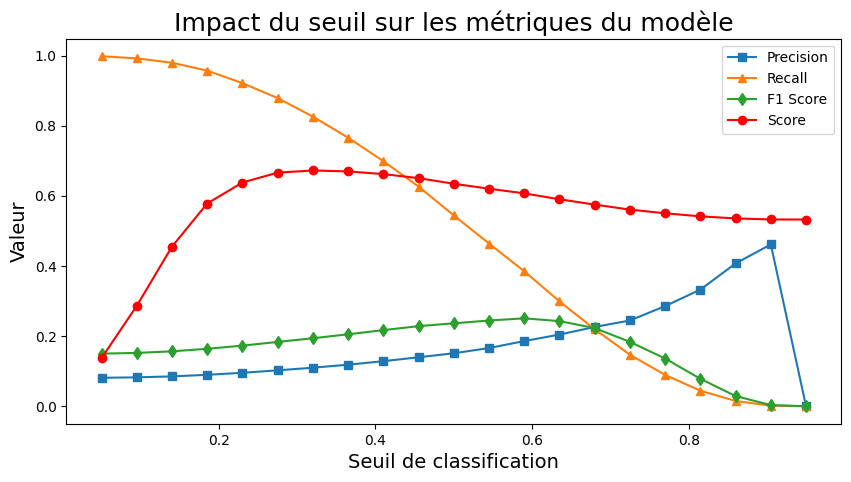

In [79]:
# Visualiser l'impact des seuils

plt.figure(figsize=(10, 5))

plt.plot(metrics[:, 0], metrics[:, 1], label="Precision", marker='s')
plt.plot(metrics[:, 0], metrics[:, 2], label="Recall", marker='^')
plt.plot(metrics[:, 0], metrics[:, 3], label="F1 Score", marker='d')
plt.plot(metrics[:, 0], metrics[:, 4], label="Score", marker='o', color="r")

plt.xlabel("Seuil de classification", fontsize=14)
plt.ylabel("Valeur", fontsize=14)
plt.title("Impact du seuil sur les métriques du modèle", fontsize=18)
plt.legend()
fig.tight_layout()

plt.show()

Seuil optimal basé sur la courbe ROC : 0.45


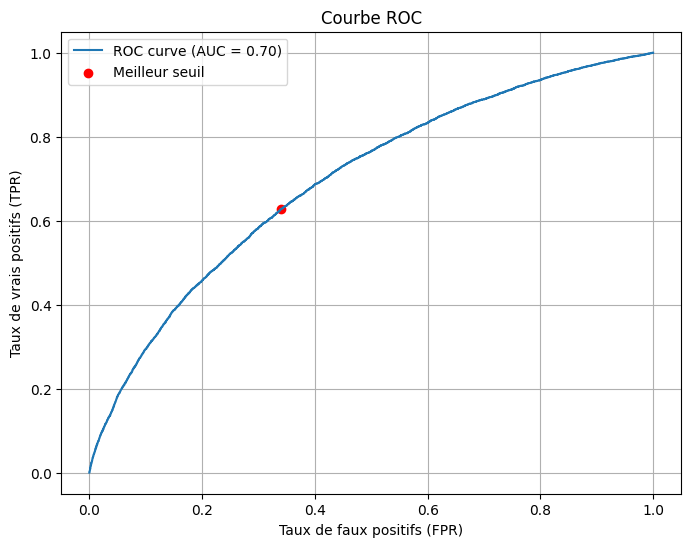

In [53]:
# Trouver le seuil optimal avec la courbe ROC
# Si vous voulez choisir un seuil optimal en fonction de la courbe ROC, vous pouvez utiliser le point où sensibilité (recall) et spécificité sont bien équilibrées.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Trouver le meilleur seuil (maximisant TPR - FPR)
best_threshold = thresholds[np.argmax(tpr - fpr)]
print(f"Seuil optimal basé sur la courbe ROC : {best_threshold:.2f}")

# Afficher la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], color='red', label="Meilleur seuil")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend()
plt.grid()
plt.show()

In [55]:
results = pd.DataFrame(metrics)
results.rename(columns={0: "Seuil", 1: "precision", 2: "Recall", 3: "F1 score", 4: "Score"}, inplace=True)
results

,Seuil,precision,Recall,F1 score,Score
0,0.050,0.081086,0.998389,0.149990,0.137029
1,0.095,0.082355,0.992213,0.152086,0.286206
2,0.140,0.085075,0.979860,0.156557,0.455163
3,0.185,0.089617,0.957304,0.163891,0.578222
4,0.230,0.095357,0.921590,0.172831,0.638132
5,0.275,0.102361,0.879028,0.183369,0.666321
6,0.320,0.109857,0.826128,0.193927,0.672437
7,0.365,0.118449,0.765977,0.205172,0.669783
8,0.410,0.128453,0.699248,0.217036,0.662141
9,0.455,0.139671,0.626477,0.228418,0.650656


In [57]:
results[results["Score"] == results["Score"].max()]

,Seuil,precision,Recall,F1 score,Score
6,0.32,0.109857,0.826128,0.193927,0.672437


## Feature importance

In [ ]:
# Créer un explainer SHAP
# Appliquer les mêmes étapes de prétraitement que celles utilisées lors de l'entraînement
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir les données en DMatrix
# dmatrix_train = xgb.DMatrix(X_train_scaled, label=y_train)
# dmatrix_test = xgb.DMatrix(X_test_scaled, label=y_test)

# Utiliser SHAP pour expliquer le modèle
explainer = shap.Explainer(loaded_model, feature_names=X_test.columns)
shap_values = explainer(X_test_scaled)


In [ ]:
# Créez la figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10), gridspec_kw={'wspace': 0.5})

# Premier graphique SHAP
shap.plots.bar(shap_values, max_display=25, show=False, ax=ax1)
ax1.set_title("Summary plot")

# Deuxième graphique SHAP
plt.sca(ax2)
shap.plots.beeswarm(shap_values, max_display=25, show=False)
ax2.set_title("Beeswarn plot")

# Supprimer les labels sur le second graphique
ax2.set_yticklabels([])
ax2.set_ylim(ax2.get_ylim()[0]* 1.5, ax2.get_ylim()[1] * 1.02)

# Ajustez la mise en page et affichez
plt.tight_layout()
plt.show()

EXT_SOURCE_2 : Normalized score from external data source
DAYS_BIRTH : Client's age in days at the time of application
BURO_DAYS_CREDIT_MAX : Maximum of how many days before current application did client apply for Credit Bureau credit
PREV_CNT_PAYMENT_MEAN : Mean of term of previous credit at application of the previous application
BURO_DAYS_CREDIT_MIN :Minimum of how many days before current application did client apply for Credit Bureau credit
CODE_GENDER : Gender of the client (M=1, F=0)
DAYS_ID_PUBLISH : How many days before the application did client change the identity document with which he applied for the loan

In [ ]:
y_test.loc[y_test["TARGET"] == 1, :].head(2)

In [ ]:
shap.plots.waterfall(shap_values[0], max_display=20)

In [ ]:
shap.plots.waterfall(shap_values[18], max_display=20)

## Next steps

Sauvegarder un pipeline complet de modélisation. MLFLOW
    Scaler,
    prediction
    ??? feature importance local
Enregistrer via mlflow
Déployer le modèle (local pour test, puis cloud) 
interface avec streamlite

evidently pour datadrift

## Final model

In [ ]:
pipeline = Pipeline([("scaler", RobustScaler()), ("model", xgb.XGBClassifier())])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
pipeline.predict(X_test)

In [ ]:
from mlflow.models.signature import infer_signature

In [ ]:
signature = infer_signature(X_train, y_train)

In [ ]:
import mlflow.xgboost

In [ ]:
mlflow.xgboost.save_model(pipeline, "client_loan_prediction", signature=signature)